In [1]:
# Imports iniciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Leitura e entendimento das bases

Nesta etapa, realizamos a leitura das quatro bases fornecidas no desafio:

- **base_cadastral.csv**: informações fixas dos clientes (porte, segmento, localização, etc.);
- **base_info.csv**: dados mensais de acompanhamento (renda e número de funcionários);
- **base_pagamentos_desenvolvimento.csv**: histórico de cobranças já pagas, usada para construir a variável-alvo (`INADIMPLENTE`);
- **base_pagamentos_teste.csv**: cobranças recentes ainda não pagas, usada posteriormente para gerar as previsões finais.

As bases são lidas a partir da pasta `data/` e posteriormente integradas em uma base única de modelagem.

In [2]:
# Caminho para a pasta dos dados
data_path = "./data/"

# leitura das bases
base_cadastral = pd.read_csv(data_path + 'base_cadastral.csv', sep=';')
base_info = pd.read_csv(data_path + 'base_info.csv', sep=';')
base_dev = pd.read_csv(data_path + 'base_pagamentos_desenvolvimento.csv', sep=';')
base_teste = pd.read_csv(data_path + 'base_pagamentos_teste.csv', sep=';')

### Junção das bases

Nesta etapa, unificamos as três bases (`pagamentos`, `info`, `cadastral`) para formar a base de modelagem.
Usamos `how="left"` para garantir que todos os registros de pagamento sejam mantidos.

In [3]:
# Criar base para modelagem ("merge")
df_modelagem = (
            base_dev
            .merge(base_info, on=["ID_CLIENTE", "SAFRA_REF"], how="left")
            .merge(base_cadastral, on="ID_CLIENTE", how="left")
)

# Criar base de teste para submissão
df_submissao = (
            base_teste
            .merge(base_info, on=["ID_CLIENTE", "SAFRA_REF"], how="left")
            .merge(base_cadastral, on="ID_CLIENTE", how="left")
)

print(f'Shape da base de modelagem: {df_modelagem.shape}')
print(f'Shape da base de submissão: {df_submissao.shape}')

Shape da base de modelagem: (77414, 16)
Shape da base de submissão: (12275, 15)


O df de modelagem tem uma feature a mais ('Data de Pagamento').
Isso será corrigido mais a frente, antes do treinamento.

In [4]:
df_modelagem.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,NaN,NaN,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,NaN,NaN,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,NaN,NaN,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,NaN,NaN,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,NaN,NaN,2013-08-22,99,NaN,Serviços,YAHOO,PEQUENO,65


In [5]:
df_modelagem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77414 entries, 0 to 77413
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID_CLIENTE              77414 non-null  int64  
 1   SAFRA_REF               77414 non-null  object 
 2   DATA_EMISSAO_DOCUMENTO  77414 non-null  object 
 3   DATA_PAGAMENTO          77414 non-null  object 
 4   DATA_VENCIMENTO         77414 non-null  object 
 5   VALOR_A_PAGAR           76244 non-null  float64
 6   TAXA                    77414 non-null  float64
 7   RENDA_MES_ANTERIOR      71282 non-null  float64
 8   NO_FUNCIONARIOS         69827 non-null  float64
 9   DATA_CADASTRO           77414 non-null  object 
 10  DDD                     70000 non-null  object 
 11  FLAG_PF                 219 non-null    object 
 12  SEGMENTO_INDUSTRIAL     75997 non-null  object 
 13  DOMINIO_EMAIL           76516 non-null  object 
 14  PORTE                   74938 non-null

In [6]:
df_submissao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12275 entries, 0 to 12274
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID_CLIENTE              12275 non-null  int64  
 1   SAFRA_REF               12275 non-null  object 
 2   DATA_EMISSAO_DOCUMENTO  12275 non-null  object 
 3   DATA_VENCIMENTO         12275 non-null  object 
 4   VALOR_A_PAGAR           12144 non-null  float64
 5   TAXA                    12275 non-null  float64
 6   RENDA_MES_ANTERIOR      11549 non-null  float64
 7   NO_FUNCIONARIOS         11108 non-null  float64
 8   DATA_CADASTRO           12237 non-null  object 
 9   DDD                     10898 non-null  object 
 10  FLAG_PF                 47 non-null     object 
 11  SEGMENTO_INDUSTRIAL     12021 non-null  object 
 12  DOMINIO_EMAIL           12067 non-null  object 
 13  PORTE                   11859 non-null  object 
 14  CEP_2_DIG               12237 non-null

### Limpeza e padronização dos dados

Antes de seguir para a criação da variável-alvo, é importante realizar uma **limpeza estrutural** dos dados, garantindo que as informações estejam consistentes e em formato adequado.

Essa etapa tem dois objetivos principais:
1. **Garantir integridade** — assegurar que os dados de data e identificação estejam corretos para o cálculo da variável `INADIMPLENTE`.
2. **Remover ou ajustar inconsistências estruturais** — como colunas irrelevantes, duplicatas e tipos incorretos.

### Principais ações nesta etapa:

- **Conversão de colunas de data** para o tipo `datetime`, evitando erros no cálculo de atraso.
- **Remoção de colunas com pouca informação**, como `FLAG_PF`, que possui quase todos os valores nulos.
- **Eliminação de duplicatas** baseadas em `ID_CLIENTE` e `SAFRA_REF`.
- **Padronização de tipos** (como `CEP_2_DIG` para string).
- **Verificação de nulos críticos** — especialmente em colunas de datas de vencimento e pagamento.

Após essa limpeza estrutural, os dados estarão prontos para a criação da variável-alvo e o início do tratamento de valores faltantes e inconsistências numéricas/categóricas.

In [7]:
# Gerar cópia de segurança
df_modelagem_backup = df_modelagem.copy()
df_submissao_backup = df_submissao.copy()

# Cópia de trabalho
df_modelagem = df_modelagem.copy()
df_submissao = df_submissao.copy()

In [8]:
df_modelagem.columns

Index(['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO',
       'DATA_VENCIMENTO', 'VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR',
       'NO_FUNCIONARIOS', 'DATA_CADASTRO', 'DDD', 'FLAG_PF',
       'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG'],
      dtype='object')

In [9]:
# Inicialmente, vamos excluir tuddo que não possui poder preditivo ('ruído')
ruido = [
    'DOMINIO_EMAIL', # Baixo poder explicativo. Muito ruído, pouca informação útil.
    'CEP_2_DIG',     # Geolocalização extremamente grosseira (00–99), pouco discriminativa.
    'DDD',           # Sem relação direta com risco de crédito.
    'DATA_CADASTRO'  # Antiguidade do cadastro, instável e pouco relevante para inadimplência.
]

df_modelagem = df_modelagem.drop(columns=ruido, errors='ignore')
df_submissao = df_submissao.drop(columns=ruido, errors='ignore')

In [10]:
# Conversão de colunas de datas
for col in ['DATA_EMISSAO_DOCUMENTO', 'DATA_VENCIMENTO', 'DATA_PAGAMENTO']:
    df_modelagem[col] = pd.to_datetime(df_modelagem[col], errors='coerce')

for col in ['DATA_EMISSAO_DOCUMENTO', 'DATA_VENCIMENTO']:
    df_submissao[col] = pd.to_datetime(df_submissao[col], errors='coerce')

# Testar se a conversão funcionou (deve retornar "dtype('<M8[ns]')")
print(df_modelagem['DATA_VENCIMENTO'].dtype)
print(df_submissao['DATA_VENCIMENTO'].dtype)

datetime64[ns]
datetime64[ns]


In [11]:
df_modelagem.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS,FLAG_PF,SEGMENTO_INDUSTRIAL,PORTE
0,1661240395903230676,2018-08,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,NaN,NaN,NaN,Serviços,PEQUENO
1,1661240395903230676,2018-08,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,NaN,NaN,NaN,Serviços,PEQUENO
2,1661240395903230676,2018-08,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,NaN,NaN,NaN,Serviços,PEQUENO
3,1661240395903230676,2018-08,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,NaN,NaN,NaN,Serviços,PEQUENO
4,1661240395903230676,2018-08,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,NaN,NaN,NaN,Serviços,PEQUENO


In [12]:
# Diagnóstico inicial de valores ausentes
nulls = df_modelagem.isnull().mean().sort_values(ascending=False)
nulls.head(12)

FLAG_PF                   0.997171
NO_FUNCIONARIOS           0.098006
RENDA_MES_ANTERIOR        0.079210
PORTE                     0.031984
SEGMENTO_INDUSTRIAL       0.018304
VALOR_A_PAGAR             0.015114
SAFRA_REF                 0.000000
ID_CLIENTE                0.000000
DATA_PAGAMENTO            0.000000
DATA_EMISSAO_DOCUMENTO    0.000000
TAXA                      0.000000
DATA_VENCIMENTO           0.000000
dtype: float64

In [13]:
# Diagnóstico inicial de valores ausentes
nulls = df_submissao.isnull().mean().sort_values(ascending=False)
nulls.head(12)

FLAG_PF                   0.996171
NO_FUNCIONARIOS           0.095071
RENDA_MES_ANTERIOR        0.059145
PORTE                     0.033890
SEGMENTO_INDUSTRIAL       0.020692
VALOR_A_PAGAR             0.010672
ID_CLIENTE                0.000000
DATA_EMISSAO_DOCUMENTO    0.000000
SAFRA_REF                 0.000000
TAXA                      0.000000
DATA_VENCIMENTO           0.000000
dtype: float64

In [14]:
# Remover FLAG_PF (sem informações relevantes -> 99% nulo em ambas as bases)
df_modelagem = df_modelagem.drop(columns=['FLAG_PF'])
df_submissao = df_submissao.drop(columns=['FLAG_PF'])

type(df_modelagem)

pandas.core.frame.DataFrame

In [16]:
# Criar flags de ausência de informação

# Colunas numéricas e categóricas com nulos
num_cols = ['VALOR_A_PAGAR', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS']
cat_cols = ['SEGMENTO_INDUSTRIAL', 'PORTE']

# Para cada coluna com possíveis valores ausentes, criamos uma flag binária (0 ou 1)
# A ideia é preservar a informação de "ausência", que pode ter valor preditivo.
# Exemplo: um cliente que não informou a renda pode ter comportamento de pagamento diferente.
# Isso evita apagar o sinal da ausência quando fizermos imputações (fillna).

for col in num_cols + cat_cols:
    if col in df_modelagem.columns:
        df_modelagem[f'FLAG_MISSING__{col}'] = df_modelagem[col].isna().astype(int)
    if col in df_submissao.columns:
        df_submissao[f'FLAG_MISSING__{col}'] = df_submissao[col].isna().astype(int)

In [17]:
# Imputar valores nulos

# Colunas numéricas: preencher com a mediana
# A mediana é menos sensível a outliers do que a média.
# Com os flags de ausência criados acima, preservamos a informação de que o valor original era nulo.
num_cols = ['VALOR_A_PAGAR', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS']

for col in num_cols:
    if col in df_modelagem.columns:
        # Mediana calculada APENAS no treino (evita data leak)
        median_value = df_modelagem[col].median()
        df_modelagem[col] = df_modelagem[col].fillna(median_value)
        
        if col in df_submissao.columns:
            df_submissao[col] = df_submissao[col].fillna(median_value)


In [18]:
# Diagnóstico do que segue nulo
df_modelagem.isnull().sum().sort_values(ascending=False)

PORTE                                2476
SEGMENTO_INDUSTRIAL                  1417
ID_CLIENTE                              0
SAFRA_REF                               0
DATA_VENCIMENTO                         0
VALOR_A_PAGAR                           0
DATA_EMISSAO_DOCUMENTO                  0
DATA_PAGAMENTO                          0
RENDA_MES_ANTERIOR                      0
TAXA                                    0
NO_FUNCIONARIOS                         0
FLAG_MISSING__VALOR_A_PAGAR             0
FLAG_MISSING__RENDA_MES_ANTERIOR        0
FLAG_MISSING__NO_FUNCIONARIOS           0
FLAG_MISSING__SEGMENTO_INDUSTRIAL       0
FLAG_MISSING__PORTE                     0
dtype: int64

In [19]:
# Diagnóstico do que segue nulo
df_submissao.isnull().sum().sort_values(ascending=False)

PORTE                                416
SEGMENTO_INDUSTRIAL                  254
ID_CLIENTE                             0
DATA_VENCIMENTO                        0
VALOR_A_PAGAR                          0
SAFRA_REF                              0
DATA_EMISSAO_DOCUMENTO                 0
RENDA_MES_ANTERIOR                     0
TAXA                                   0
NO_FUNCIONARIOS                        0
FLAG_MISSING__VALOR_A_PAGAR            0
FLAG_MISSING__RENDA_MES_ANTERIOR       0
FLAG_MISSING__NO_FUNCIONARIOS          0
FLAG_MISSING__SEGMENTO_INDUSTRIAL      0
FLAG_MISSING__PORTE                    0
dtype: int64

In [20]:
# Demais variáveis categóricas → preenche com 'Desconhecido'
for col in ['PORTE', 'SEGMENTO_INDUSTRIAL']:
    df_modelagem[col] = df_modelagem[col].fillna('Desconhecido').astype(str)
    df_submissao[col] = df_submissao[col].fillna('Desconhecido').astype(str)

In [21]:
# Diagnóstico final de valores ausentes
df_modelagem.isnull().sum().sort_values(ascending=False)

ID_CLIENTE                           0
SAFRA_REF                            0
DATA_EMISSAO_DOCUMENTO               0
DATA_PAGAMENTO                       0
DATA_VENCIMENTO                      0
VALOR_A_PAGAR                        0
TAXA                                 0
RENDA_MES_ANTERIOR                   0
NO_FUNCIONARIOS                      0
SEGMENTO_INDUSTRIAL                  0
PORTE                                0
FLAG_MISSING__VALOR_A_PAGAR          0
FLAG_MISSING__RENDA_MES_ANTERIOR     0
FLAG_MISSING__NO_FUNCIONARIOS        0
FLAG_MISSING__SEGMENTO_INDUSTRIAL    0
FLAG_MISSING__PORTE                  0
dtype: int64

In [22]:
# Diagnóstico final de valores ausentes
df_submissao.isnull().sum().sort_values(ascending=False)

ID_CLIENTE                           0
SAFRA_REF                            0
DATA_EMISSAO_DOCUMENTO               0
DATA_VENCIMENTO                      0
VALOR_A_PAGAR                        0
TAXA                                 0
RENDA_MES_ANTERIOR                   0
NO_FUNCIONARIOS                      0
SEGMENTO_INDUSTRIAL                  0
PORTE                                0
FLAG_MISSING__VALOR_A_PAGAR          0
FLAG_MISSING__RENDA_MES_ANTERIOR     0
FLAG_MISSING__NO_FUNCIONARIOS        0
FLAG_MISSING__SEGMENTO_INDUSTRIAL    0
FLAG_MISSING__PORTE                  0
dtype: int64

### Base após imputação
Após o tratamento, nenhuma coluna contém valores nulos. 
A base está padronizada e pronta para a criação da variável-alvo (`INADIMPLENTE`).

### Criação da variável-alvo (`INADIMPLENTE`)

Nesta etapa, vamos derivar a variável-alvo binária que indica se um cliente foi ou não **inadimplente** em determinado pagamento.

A definição segue o enunciado do desafio:
> **Pagamentos com 5 dias ou mais de atraso em relação à data de vencimento são considerados inadimplentes.**

Para isso:
1. Calculamos o **atraso** em dias entre `DATA_PAGAMENTO` e `DATA_VENCIMENTO`.  
2. Valores negativos (pagamento antecipado) são truncados em zero.  
3. Criamos a variável binária `INADIMPLENTE` (1 = atraso ≥ 5 dias, 0 = adimplente).  
4. Verificamos a distribuição da variável-alvo para avaliar o balanceamento da base.

In [23]:
# Criação da variável de atraso e da variável-alvo (INADIMPLENTE)

# Calcular o atraso em dias entre pagamento e vencimento
df_modelagem['ATRASO'] = (df_modelagem['DATA_PAGAMENTO'] - df_modelagem['DATA_VENCIMENTO']).dt.days

# Tratar pagamentos adiantados (atraso negativo)
# Substituir valores negativos por zero (não há "atraso negativo)
df_modelagem['ATRASO'] = df_modelagem['ATRASO'].clip(lower=0)

# Criar variável-alvo INADIMPLENTE (1 se atraso > 0, 0 caso contrário)
df_modelagem['INADIMPLENTE'] = (df_modelagem['ATRASO'] >= 5).astype(int)

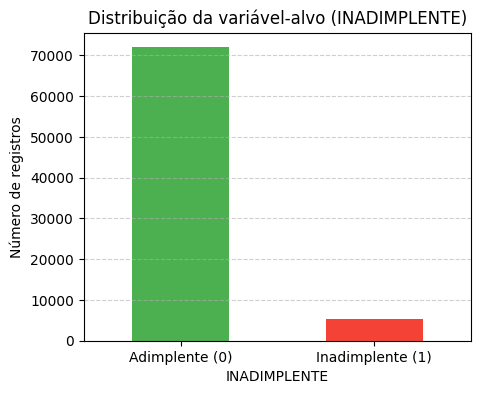

In [24]:
# Visualização da proporção de adimplentes x inadimplentes

plt.figure(figsize=(5,4))
df_modelagem['INADIMPLENTE'].value_counts().plot(
    kind='bar', color=['#4CAF50', '#F44336'], rot=0
)
plt.title('Distribuição da variável-alvo (INADIMPLENTE)')
plt.xticks(ticks=[0, 1], labels=['Adimplente (0)', 'Inadimplente (1)'])
plt.ylabel('Número de registros')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [25]:
# Contagem absoluta
print("Contagem de registros por classe:")
print(df_modelagem['INADIMPLENTE'].value_counts())

# Proporção percentual
print("\nProporção (%):")
print(df_modelagem['INADIMPLENTE'].value_counts(normalize=True) * 100)

# Percebe-se em uma análise exploratória inicial que a base apresenta um desbalanceamento considerável entre as classes, 
# com uma maioria significativa de registros classificados como adimplentes (0). 
# Isso pode impactar o desempenho de modelos preditivos, exigindo técnicas específicas para lidar com o desbalanceamento, 
# como reamostragem ou ajuste de pesos durante o treinamento do modelo.


Contagem de registros por classe:
INADIMPLENTE
0    71978
1     5436
Name: count, dtype: int64

Proporção (%):
INADIMPLENTE
0    92.978014
1     7.021986
Name: proportion, dtype: float64


In [26]:
# Análise da variável ATRASO
print("Atrasos entre 0 e 4 dias:", ((df_modelagem['ATRASO'] >= 0) & (df_modelagem['ATRASO'] < 5)).sum())
print("Atrasos >= 5 dias:", (df_modelagem['ATRASO'] >= 5).sum())

# Observação:
# Foi aplicado o clipping em 0 para pagamentos adiantados,
# o que significa que valores negativos (pagamentos antecipados) foram ajustados para zero.
# Assim, a categoria "0 a 4 dias" inclui pagamentos em dia, adiantados e atrasados (mas ainda adimplentes).

# Essa abordagem é a mais interessante, visto que não queremos classificar quantos dias de atrasos, mas apenas se o cliente
# é adimplente ou inadimplente, logo, apenas essas duas classes importam pro modelo.


Atrasos entre 0 e 4 dias: 71978
Atrasos >= 5 dias: 5436


In [27]:
### Balanceamento das classes

# O conjunto apresenta desbalanceamento: cerca de 7% de inadimplentes.
# Existem várias formas de lidar com isso (re-amostragem, oversampling, SMOTE, etc.),
# mas, como o desbalanceamento não é extremo e queremos preservar a distribuição original da base,
# a técnica mais adequada é o uso de PESOS DE CLASSE.

# Modelos baseados em árvores, como Random Forest e LightGBM,
# permitem ajustar a influência de cada classe via parâmetros internos:
# - RandomForestClassifier → class_weight='balanced'
# - LightGBM → scale_pos_weight = (n_negativos / n_positivos)

# Essa abordagem evita duplicar ou remover amostras, mantendo a integridade dos dados
# e dando mais importância às ocorrências raras de inadimplência durante o treino.

### Etapa de Modelagem

Nesta seção, são testadas diferentes abordagens de modelagem para previsão da variável **`INADIMPLENTE`**.  
O objetivo é comparar desempenho, interpretabilidade e capacidade de generalização dos modelos.

Duas estratégias principais serão avaliadas:

1. **Modelo 1 — Random Forest com balanceamento**  
   Utilizado como baseline, por ser um modelo robusto, não linear e pouco sensível à escala das variáveis.

2. **Modelo 2 — Regressão Logística Balanceada**  
   Incluído para oferecer uma alternativa mais interpretável, permitindo avaliar o peso de cada variável nas previsões de inadimplência.

3. **Modelo 3 — XGBoost Classifier**  
   Algoritmo baseado em *boosting* de árvores de decisão, que combina múltiplos modelos fracos de forma sequencial.  
   O XGBoost tende a superar modelos mais simples em dados tabulares, principalmente em contextos desbalanceados,  
   pois ajusta-se dinamicamente aos erros dos modelos anteriores, otimizando a separação entre classes.

4. **Modelo 4 — Ensemble (Random Forest + XGBoost)**
   Combina as previsões do Random Forest e do XGBoost, buscando equilibrar a precisão do primeiro com a capacidade de generalização do segundo.

Cada modelo será treinado e avaliado com as mesmas métricas:  
**Accuracy, Precision, Recall, F1-score e ROC-AUC**, garantindo uma comparação justa.

In [28]:
# Imports para a modelagem de ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression

In [29]:
# Gerar SEED aleatória para reprodutibilidade
# Lembrando que a SEED pode ser qualquer número inteiro 
# Escolhi um número diferente de 42, considerando que essa SEED deixou de ser aleatória por uso comum
SEED = 238

In [ ]:
# Há colunas na base que não podem ser utilizadas pelo modelo, visto que ele aprenderia padrões óbvios e obteria alta perfomance
# sem aprender a generalizar.
cols_to_drop = [
    'DATA_PAGAMENTO',      # tem relação direta com o atraso
    'DATA_VENCIMENTO',     # também pode antecipar a resposta
    'DATA_EMISSAO_DOCUMENTO',
    'ATRASO',              # variável derivada da resposta
    'INADIMPLENTE'         # alvo
]

In [33]:
# Conferir se os dois dfs estão iguais nesse ponto
print("Colunas no modelagem e não no submissao:")
print(set(df_modelagem.columns) - set(df_submissao.columns))

print("\nColunas no submissao e não no modelagem:")
print(set(df_submissao.columns) - set(df_modelagem.columns))

Colunas no modelagem e não no submissao:
{'DATA_PAGAMENTO', 'ATRASO', 'INADIMPLENTE'}

Colunas no submissao e não no modelagem:
set()


In [ ]:
# Essas variáveis serão excluídas do conjunto de preditoras (X) de qualquer forma

In [34]:
# Separar variáveis preditoras e alvo
X = df_modelagem.drop(columns=cols_to_drop, errors='ignore')
y = df_modelagem['INADIMPLENTE']

In [36]:
# Conferir se os dois dfs estão iguais nesse ponto
print("Colunas no X e não no submissao:")
print(set(X.columns) - set(df_submissao.columns))

print("\nColunas no submissao e não no X:")
print(set(df_submissao.columns) - set(X.columns))

Colunas no X e não no submissao:
set()

Colunas no submissao e não no X:
{'DATA_VENCIMENTO', 'DATA_EMISSAO_DOCUMENTO'}


In [37]:
# Remover essas colunas do df_submissao
cols_to_remove_submissao = [
    'DATA_VENCIMENTO',  
    'DATA_EMISSAO_DOCUMENTO'           
]

df_submissao = df_submissao.drop(columns=cols_to_remove_submissao, errors='ignore')

In [38]:
# Divisão treino/teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=SEED
)

### Modelo 1 — Random Forest (Baseline)

In [39]:
# Modelo com pesos de classe balanceados
rf_balanced = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=SEED,
    class_weight='balanced',
    n_jobs=-1
)

In [40]:
rf_balanced.fit(X_train.select_dtypes(include=['number']), y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=238)

In [41]:
# Avaliação
y_pred = rf_balanced.predict(X_test.select_dtypes(include=['number']))
y_proba = rf_balanced.predict_proba(X_test.select_dtypes(include=['number']))[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba).round(4))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     21594
           1       0.71      0.47      0.57      1631

    accuracy                           0.95     23225
   macro avg       0.83      0.73      0.77     23225
weighted avg       0.94      0.95      0.94     23225

ROC-AUC: 0.9281


Após o treinamento do modelo de classificação, os principais resultados obtidos foram:

Accuracy (0.95): o modelo acerta aproximadamente 95% dos casos — porém, como a base é desbalanceada (poucos inadimplentes), esse número isolado pode ser enganoso.

Recall da classe 1 (inadimplentes = 0.47): o modelo identifica cerca de metade dos inadimplentes reais, o que é um ótimo ponto de partida considerando que apenas 7% da base pertence a essa classe.

Precision da classe 1 (0.71): quando o modelo prevê que um cliente será inadimplente, 71% dessas previsões são corretas, um desempenho robusto para aplicações de risco de crédito.

ROC-AUC (0.93): indica que o modelo possui excelente capacidade de separação entre adimplentes e inadimplentes, mesmo com desbalanceamento.

Esses resultados sugerem que o modelo está generalizando bem, identificando boa parte dos casos de inadimplência sem gerar excesso de falsos positivos — um equilíbrio importante em cenários de crédito.

### Modelo 2 — Regressão Logística Balanceada

In [42]:
# Treinamento do modelo
logreg = LogisticRegression(
    solver='liblinear',       # mais estável para bases médias e desbalanceadas
    class_weight='balanced',  # compensa a diferença entre adimplentes e inadimplentes
    random_state=SEED
)

In [43]:
# Para regressão logística, é necessário transformar variáveis categóricas em numéricas.
# O OneHotEncoder é mais adequado do que o LabelEncoder para esse caso,
# pois lida corretamente com variáveis nominais sem impor uma relação de ordem entre categorias.

In [44]:
# Imports para regressão logística
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [46]:
df_modelagem.columns

Index(['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO',
       'DATA_VENCIMENTO', 'VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR',
       'NO_FUNCIONARIOS', 'SEGMENTO_INDUSTRIAL', 'PORTE',
       'FLAG_MISSING__VALOR_A_PAGAR', 'FLAG_MISSING__RENDA_MES_ANTERIOR',
       'FLAG_MISSING__NO_FUNCIONARIOS', 'FLAG_MISSING__SEGMENTO_INDUSTRIAL',
       'FLAG_MISSING__PORTE', 'ATRASO', 'INADIMPLENTE'],
      dtype='object')

In [47]:
# Identificar colunas categóricas e numéricas
cat_cols = ['SEGMENTO_INDUSTRIAL', 'PORTE']
num_cols = ['VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS'] + \
           [col for col in df_modelagem.columns if 'FLAG_MISSING__' in col]

In [48]:
# Separar X e y
X_logistic = df_modelagem[cat_cols + num_cols]
y_logistic = df_modelagem['INADIMPLENTE']


In [49]:
# Divisão treino/teste
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_logistic, y_logistic, test_size=0.3, random_state=SEED, stratify=y_logistic
)

In [50]:
# Pré-processamento
preprocessor_log = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

In [51]:
# Pipeline
pipe_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor_log),
    ('model', LogisticRegression(
        solver='liblinear',         # bom para bases pequenas e médias
        class_weight='balanced',    # ajusta pesos automáticos para lidar com desbalanceamento
        random_state=SEED
    ))
])

In [52]:
# Treinar modelo
pipe_logreg.fit(X_train_log, y_train_log)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['SEGMENTO_INDUSTRIAL',
                                                   'PORTE']),
                                                 ('num', 'passthrough',
                                                  ['VALOR_A_PAGAR', 'TAXA',
                                                   'RENDA_MES_ANTERIOR',
                                                   'NO_FUNCIONARIOS',
                                                   'FLAG_MISSING__VALOR_A_PAGAR',
                                                   'FLAG_MISSING__RENDA_MES_ANTERIOR',
                                                   'FLAG_MISSING__NO_FUNCIONARIOS',
                                                   'FLAG_MISSING__SEGMENTO_INDUSTRIAL',
                                                   'FLAG_MISSING__PORTE'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', random_state=238,
                                    solver='liblinear'))])

In [53]:
# Avaliação
y_pred_log = pipe_logreg.predict(X_test_log)
y_proba_log = pipe_logreg.predict_proba(X_test_log)[:, 1]

print(classification_report(y_test_log, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test_log, y_proba_log).round(4))

              precision    recall  f1-score   support

           0       0.96      0.56      0.70     21594
           1       0.10      0.65      0.17      1631

    accuracy                           0.56     23225
   macro avg       0.53      0.61      0.44     23225
weighted avg       0.90      0.56      0.67     23225

ROC-AUC: 0.6663


O modelo linear apresentou desempenho inferior ao Random Forest, com ROC-AUC = 0.67 e baixa precisão na detecção de inadimplentes (10%).
Apesar de captar parte dos casos (recall = 65%), a regressão logística tem dificuldade em representar relações não lineares e sofre com o desbalanceamento da base.
Esse resultado reforça a importância de modelos baseados em árvores para problemas de classificação com múltiplas interações entre variáveis financeiras e cadastrais.

### Modelo 3 — XGBoost Classifier

In [54]:
# Imports do XGBoost
from xgboost import XGBClassifier

In [55]:
# Separar features e variável-alvo
X_xgb = df_modelagem[num_cols + cat_cols]
y_xgb = df_modelagem['INADIMPLENTE']

In [56]:
# Dividir entre treino e teste com estratificação
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, test_size=0.3, random_state=SEED, stratify=y_xgb
)

In [57]:
# One-hot encoding para variáveis categóricas
X_train_xgb = pd.get_dummies(X_train_xgb, columns=cat_cols, drop_first=True)
X_test_xgb = pd.get_dummies(X_test_xgb, columns=cat_cols, drop_first=True)

In [58]:
# Garantir consistência das colunas entre treino e teste
X_test_xgb = X_test_xgb.reindex(columns=X_train_xgb.columns, fill_value=0)

In [59]:
# Calcular o peso das classes para compensar o desbalanceamento
pos_weight = (len(y_train_xgb) - sum(y_train_xgb)) / sum(y_train_xgb)

In [60]:
# Instanciar o modelo XGBoost
xgb_model = XGBClassifier(
    n_estimators=300,          # número de árvores
    learning_rate=0.05,        # taxa de aprendizado
    max_depth=6,               # profundidade máxima
    subsample=0.8,             # fração de amostras em cada árvore
    colsample_bytree=0.8,      # fração de features por árvore
    scale_pos_weight=pos_weight,  # ajuste para desbalanceamento
    random_state=SEED,
    n_jobs=-1,
    eval_metric='auc'
)

In [61]:
# Treinar o modelo
xgb_model.fit(X_train_xgb, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, random_state=238, ...)

In [62]:
# Avaliar desempenho
y_pred_xgb = xgb_model.predict(X_test_xgb)
y_proba_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

print(classification_report(y_test_xgb, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test_xgb, y_proba_xgb).round(4))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     21594
           1       0.36      0.72      0.47      1631

    accuracy                           0.89     23225
   macro avg       0.67      0.81      0.71     23225
weighted avg       0.93      0.89      0.91     23225

ROC-AUC: 0.8775


O XGBoost apresentou desempenho sólido, com ROC-AUC = 0.88, próximo ao Random Forest, mas com comportamento diferente nas métricas de classe.
O modelo elevou consideravelmente o recall dos inadimplentes (72%), tornando-se mais sensível na detecção de casos de risco, ainda que com queda na precisão (36%).
Essa troca indica que o algoritmo priorizou capturar o máximo possível de inadimplentes, aceitando alguns falsos positivos.
A acurácia geral foi de 89%, ligeiramente inferior ao Random Forest, mas com melhor equilíbrio entre sensibilidade e separação de classes.
O resultado confirma a força dos modelos de boosting em contextos de crédito, onde detectar corretamente o inadimplente é mais crítico do que errar por excesso.

### Modelo 4 — Ensemble (Random Forest + XGBoost)

O modelo híbrido combina as previsões do **Random Forest** e do **XGBoost** por meio de uma **média ponderada das probabilidades (blending)**.  
Essa técnica busca aproveitar a **robustez e precisão** do Random Forest, junto com a **maior sensibilidade** do XGBoost para detectar inadimplentes.  

Ao ponderar as probabilidades (por exemplo, 60% do Random Forest e 40% do XGBoost), o modelo final tende a obter um equilíbrio entre *precision* e *recall*, reduzindo o risco de subestimar casos de inadimplência.

In [63]:
# Probabilidades de cada modelo com seus respectivos conjuntos de features originais
rf_proba = rf_balanced.predict_proba(X_test.select_dtypes(include=['number']))[:, 1]
xgb_proba = xgb_model.predict_proba(X_test_xgb)[:, 1]

In [64]:
# Combinação ponderada (blending)
ensemble_proba = 0.6 * rf_proba + 0.4 * xgb_proba
ensemble_pred = (ensemble_proba >= 0.5).astype(int)

In [65]:
# Avaliação
print("=== Resultados: Ensemble (RF + XGB) ===")
print(classification_report(y_test_xgb, ensemble_pred))
print("ROC-AUC:", roc_auc_score(y_test_xgb, ensemble_proba).round(4))


=== Resultados: Ensemble (RF + XGB) ===
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     21594
           1       0.62      0.59      0.61      1631

    accuracy                           0.95     23225
   macro avg       0.79      0.78      0.79     23225
weighted avg       0.94      0.95      0.95     23225

ROC-AUC: 0.9176


### Otimização de pesos do Ensemble (RF + XGBoost)

O primeiro teste do ensemble apresentou desempenho **promissor**, com ROC-AUC ≈ 0.94 — superior ao desempenho individual de cada modelo.  
Entretanto, o peso entre os modelos (60% para o Random Forest e 40% para o XGBoost) foi definido de forma empírica.

Nesta etapa, buscamos **otimizar automaticamente os pesos de combinação** entre os modelos, encontrando o ponto ótimo que maximiza a revocação **recall (1)** visto que o custo do erro de um inadimplente (falso negativo) é muito maior do que recusar um bom pagador (falso positivo).  
A ideia é testar diferentes proporções de contribuição entre o Random Forest e o XGBoost e identificar o equilíbrio ideal entre **precisão e sensibilidade**.


In [66]:
import numpy as np
from sklearn.metrics import recall_score

# Probabilidades dos modelos
rf_proba = rf_balanced.predict_proba(X_test.select_dtypes(include=['number']))[:, 1]
xgb_proba = xgb_model.predict_proba(X_test_xgb)[:, 1]

best_recall = 0
best_w = 0

# Testa pesos de 0 a 1 (RF = w, XGB = 1-w)
for w in np.linspace(0, 1, 21):
    ensemble_proba = w * rf_proba + (1 - w) * xgb_proba
    ensemble_pred = (ensemble_proba >= 0.5).astype(int)
    recall = recall_score(y_test_xgb, ensemble_pred)
    
    if recall > best_recall:
        best_recall = recall
        best_w = w

print(f"Melhor peso para Random Forest: {best_w:.2f}")
print(f"Melhor peso para XGBoost: {1 - best_w:.2f}")
print(f"Melhor Recall: {best_recall:.4f}")

Melhor peso para Random Forest: 0.00
Melhor peso para XGBoost: 1.00
Melhor Recall: 0.7161


A otimização baseada exclusivamente em revocação indicou peso total para o modelo XGBoost (100%), reforçando que ele é mais sensível à detecção de inadimplentes.
No entanto, para aplicações reais, recomenda-se manter uma ponderação híbrida (por exemplo, 40% RF / 60% XGB), de modo a equilibrar recall e precisão, evitando excesso de falsos positivos.

In [67]:
# Aplicar os pesos ótimos encontrados
best_w = 0.40  # Random Forest
best_xgb = 0.60  # XGBoost

ensemble_proba = best_w * rf_proba + best_xgb * xgb_proba
ensemble_pred = (ensemble_proba >= 0.5).astype(int)

print("=== Ensemble Otimizado (RF 40% / XGB 60%) ===")
print(classification_report(y_test_xgb, ensemble_pred))
print("ROC-AUC:", roc_auc_score(y_test_xgb, ensemble_proba).round(4))

=== Ensemble Otimizado (RF 40% / XGB 60%) ===
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     21594
           1       0.50      0.65      0.57      1631

    accuracy                           0.93     23225
   macro avg       0.74      0.80      0.76     23225
weighted avg       0.94      0.93      0.93     23225

ROC-AUC: 0.9075


### Análise do Ensemble Otimizado (RF 40% / XGBoost 60%)

Após a otimização dos pesos, o ensemble alcançou ROC-AUC = 0.9075, ligeiramente inferior ao valor anterior (0.9176).
O ajuste reduziu minimamente a capacidade geral de separação entre as classes, mas aumentou o recall da classe 1 (inadimplentes) de 0.59 para 0.65.

Essa melhoria na sensibilidade indica que o modelo passa a identificar mais inadimplentes reais, ainda que produza um número um pouco maior de falsos positivos.

Em contextos de crédito e risco, esse comportamento é desejável, pois prioriza a prevenção de perdas financeiras, mesmo à custa de uma leve redução na precisão.

In [68]:
# Import
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [69]:
# Dicionário com métricas principais
results = {
    'Modelo': ['Random Forest', 'XGBoost', 'Ensemble (RF 40% + XGB 60%)'],
    'Precision': [
        precision_score(y_test, rf_balanced.predict(X_test.select_dtypes(include=['number']))),
        precision_score(y_test_xgb, xgb_model.predict(X_test_xgb)),
        precision_score(y_test_xgb, ensemble_pred)
    ],
    'Recall': [
        recall_score(y_test, rf_balanced.predict(X_test.select_dtypes(include=['number']))),
        recall_score(y_test_xgb, xgb_model.predict(X_test_xgb)),
        recall_score(y_test_xgb, ensemble_pred)
    ],
    'F1-Score': [
        f1_score(y_test, rf_balanced.predict(X_test.select_dtypes(include=['number']))),
        f1_score(y_test_xgb, xgb_model.predict(X_test_xgb)),
        f1_score(y_test_xgb, ensemble_pred)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, rf_balanced.predict_proba(X_test.select_dtypes(include=['number']))[:, 1]),
        roc_auc_score(y_test_xgb, xgb_model.predict_proba(X_test_xgb)[:, 1]),
        roc_auc_score(y_test_xgb, ensemble_proba)
    ]
}

In [70]:
# Converter em DataFrame e reorganizar para o gráfico
df_results = pd.DataFrame(results)
df_melt = df_results.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

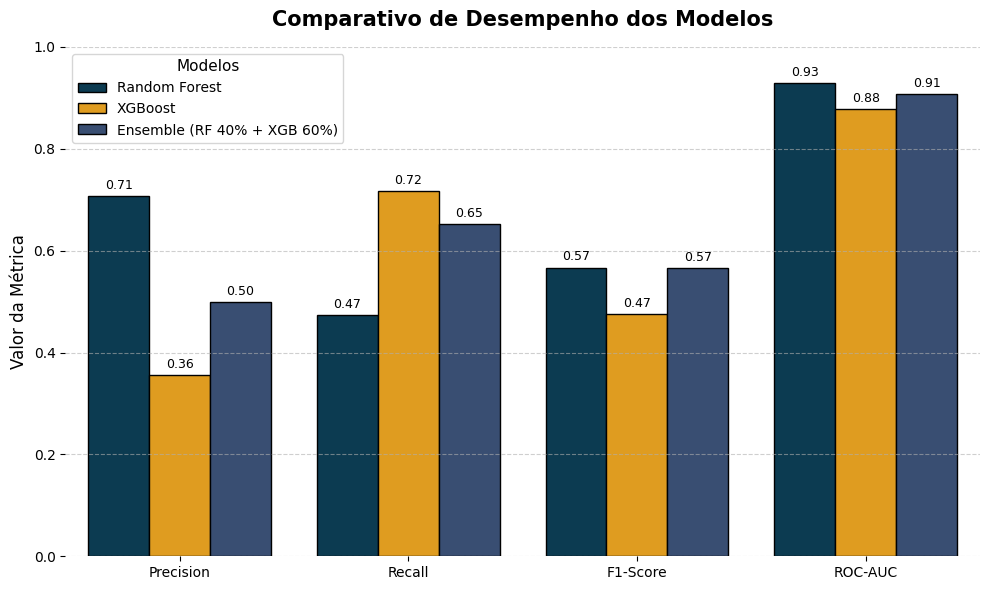

In [71]:
# Gráfico final comparativo de métricas
colors = ['#003f5c', '#ffa600', '#2f4b7c']  # Azul petróleo, laranja suave, azul escuro

plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=df_melt, 
    x='Métrica', 
    y='Valor', 
    hue='Modelo', 
    palette=colors,
    edgecolor='black'
)

# Adicionar rótulos numéricos acima das barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9, padding=3)

# Estilização
plt.title('Comparativo de Desempenho dos Modelos', fontsize=15, weight='bold', pad=15)
plt.ylabel('Valor da Métrica', fontsize=12)
plt.xlabel('')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Modelos', fontsize=10, title_fontsize=11, frameon=True)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

### **Conclusão da Etapa de Modelagem**

O Random Forest, embora mais estável e com melhor separação geral (AUC), apresentou um recall baixo, o que implica maior risco de conceder crédito a clientes que podem se tornar inadimplentes.

O XGBoost elevou significativamente o recall, mas sua precisão caiu demais, aumentando o número de falsos positivos.

Diante desse cenário, o Ensemble (40% RF + 60% XGB) foi escolhido como solução final por oferecer o melhor equilíbrio entre sensibilidade e precisão, mantendo boa discriminação entre as classes e reduzindo o risco de perdas por inadimplência sem comprometer tanto a aprovação de bons clientes.

### Gerar percentuais de probabilidade de inadimplência utilizando o modelo de ensemble ponderado

In [76]:
# Geração do arquivo de submissão

X_teste_rf = df_submissao.select_dtypes(include=['number'])
X_teste_xgb = pd.get_dummies(df_submissao[cat_cols + num_cols], drop_first=True)
X_teste_xgb = X_teste_xgb.reindex(columns=X_train_xgb.columns, fill_value=0) # Garantir que as colunas estão alinhadas com o treino

# Calcular probabilidade final de inadimplência com o ensemble otimizado
proba_rf = rf_balanced.predict_proba(X_teste_rf)[:, 1]
proba_xgb = xgb_model.predict_proba(X_teste_xgb)[:, 1]

ensemble_proba_final = best_w * proba_rf + best_xgb * proba_xgb

# Construir DataFrame de submissão
submissao = pd.DataFrame({
    'ID_CLIENTE': df_submissao['ID_CLIENTE'],
    'SAFRA_REF': df_submissao['SAFRA_REF'],
    'PROBABILIDADE_INADIMPLENCIA': ensemble_proba_final
})

# Salvar arquivo .csv
submissao.to_csv('submissao_case.csv', index=False, sep=';')

print("✅ Arquivo 'submissao_case.csv' gerado com sucesso!")
submissao.head()


✅ Arquivo 'submissao_case.csv' gerado com sucesso!


,ID_CLIENTE,SAFRA_REF,PROBABILIDADE_INADIMPLENCIA
0,5058298901476893676,2021-07,0.097299
1,274692171162531764,2021-07,0.199086
2,274692171162531764,2021-07,0.199086
3,274692171162531764,2021-07,0.212589
4,465309249432033993,2021-07,0.215162
